In [484]:
import time
import numpy as np                  
import matplotlib.pyplot as plt   
import pandas as pd
import math
import statsmodels.api as sm
from math import sqrt
import os.path
import datetime 

import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

import ffn

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.lda import LDA
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
#from sklearn.qda import QDA
from sklearn.svm import LinearSVC, SVC
from keras.models import load_model

In [205]:
df_btc = pd.read_csv('/home/aj/Downloads/BITSTAMP-USD.csv', index_col='Date')
df_btc.index = pd.to_datetime(df_btc.index)
df_btc.sort_index(inplace=True)
df_btc['Date'] = df_btc.index
df_btc.head()

,High,Low,Last,Bid,Ask,Volume,VWAP,Date
Date,,,,,,,,
2014-04-15,515.00,453.16,499.01,500.01,505.04,28535.844106,491.41,2014-04-15
2014-04-16,548.00,494.02,534.00,535.01,536.00,31159.941300,520.21,2014-04-16
2014-04-17,537.24,481.63,506.52,504.70,505.38,21126.375080,504.83,2014-04-17
2014-04-18,508.43,470.00,487.00,484.14,487.00,11879.484756,485.72,2014-04-18
2014-04-19,507.43,472.81,504.74,504.74,505.00,10262.195861,492.22,2014-04-19


In [206]:
df_btc.tail()

,High,Low,Last,Bid,Ask,Volume,VWAP,Date
Date,,,,,,,,
2019-09-24,9782.00,7998.00,8696.00,8690.06,8696.00,26366.707055,8851.70,2019-09-24
2019-09-25,8800.56,8216.00,8432.66,8429.62,8439.68,18545.387163,8461.39,2019-09-25
2019-09-26,8467.89,7733.99,8114.88,8114.88,8123.07,17203.357760,8140.71,2019-09-26
2019-09-27,8294.04,7866.00,8197.20,8195.00,8201.02,10303.607795,8033.29,2019-09-27
2019-09-28,8356.40,8009.84,8161.03,8153.02,8161.03,6191.048445,8164.11,2019-09-28


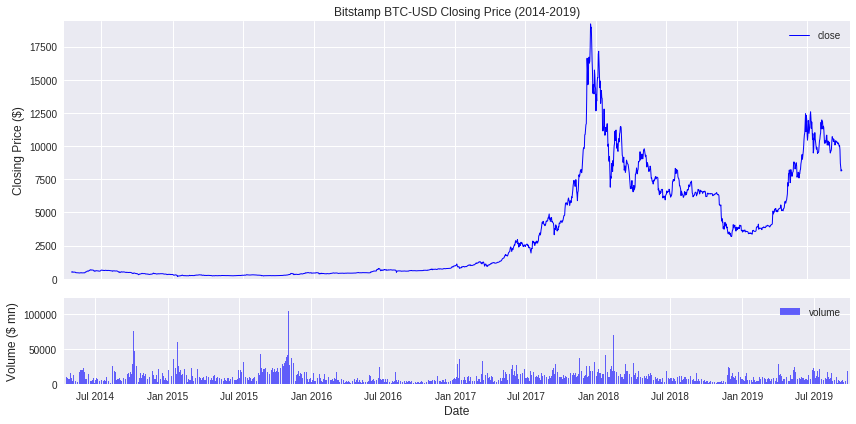

In [207]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]},figsize=(12, 6))
#ax1.set_yscale('log')
ax1.set_title('Bitstamp BTC-USD Closing Price (2014-2019)')
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ mn)',fontsize=12)
ax2.set_xlabel('Date',fontsize=12)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2014,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2014,2020) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2014,2020) for j in [1,7]])
ax1.plot(df_btc['Date'].astype(datetime.datetime),df_btc['Last'], linewidth=1, color='#0400ff')
ax2.bar(df_btc['Date'].astype(datetime.datetime).values, df_btc['Volume'], color='#0400ff', alpha=0.6)
ax1.margins(0.01)
ax2.margins(0.001)
ax2.legend(['volume'])
ax1.legend(['close'])
fig.tight_layout()
plt.show();

In [208]:
def create_lagged_series(symbol, start_date, end_date, lags=5):
    
    ts = df_btc
    tslag = pd.DataFrame(index=ts.index)
    tslag["Today"] = ts["Last"]
    tslag["Volume"] = ts["Volume"]
    
    # Create the shifted lag series of prior trading period close values
    for i in range(0, lags):
        tslag["Lag%s" % str(i+1)] = ts["Last"].shift(i+1)
        
        # Create the returns DataFrame
        tsret = pd.DataFrame(index=tslag.index)
        tsret["Volume"] = tslag["Volume"]
        tsret["Today"] = tslag["Today"].pct_change()*100
        
        # If any of the values of percentage returns equal zero, set them to
        # a small number (stops issues with QDA model in Scikit-Learn)
    for i,x in enumerate(tsret["Today"]):
        if (abs(x) < 0.0001):
            tsret["Today"][i] = 0.0001
            
            # Create the lagged percentage returns columns
    for i in range(0, lags):
        tsret["Lag%s" % str(i+1)] = \
        tslag["Lag%s" % str(i+1)].pct_change()*100
        
        # Create the "Direction" column (+1 or -1) indicating an up/down day
        tsret["Direction"] = np.sign(tsret["Today"])
        tsret = tsret[tsret.index >= start_date]
        
    return tsret

In [227]:
# Source Code: https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python/48087308
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="RdYlGn"):
    #plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.figure(figsize=(5, 4))
    sns.heatmap(df_confusion, cmap=cmap, annot=True, annot_kws={"size": 12})
    #plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()

Hit Rates/Confusion Matrices:

LR:
0.548
[[  6   3]
 [162 194]]



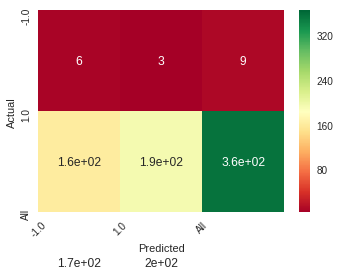

LDA:
0.548
[[  6   3]
 [162 194]]



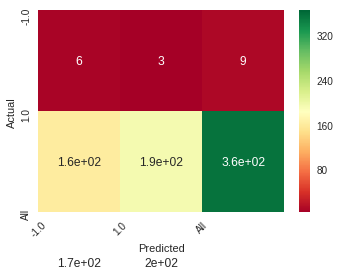

QDA:
0.551
[[ 15  11]
 [153 186]]



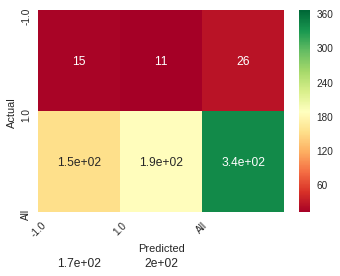

LSVC:
0.542
[[  5   4]
 [163 193]]



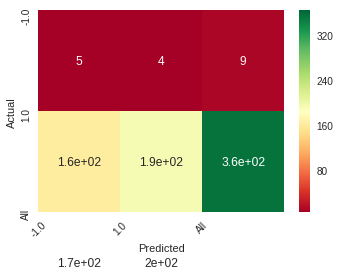

RSVM:
0.540
[[  3   3]
 [165 194]]



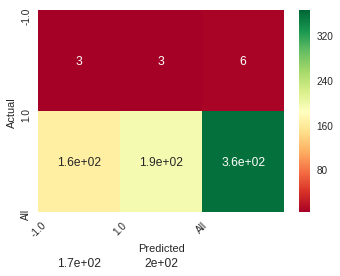

RF:
0.526
[[ 69  74]
 [ 99 123]]



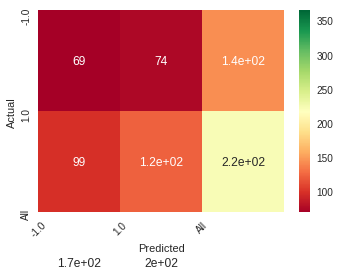

In [228]:
if __name__ == "__main__":
    
    # Create a lagged series of the S&P500 US stock market index
    snpret = create_lagged_series(
    "BTCUSD", datetime.datetime(2015,4,15),
    datetime.datetime(2019,9,28), lags=5
    )
    #Use the prior two days of returns as predictor
    #values, with direction as the response
    X = snpret[["Lag1","Lag2"]]
    y = snpret["Direction"]
    
    # The test data is split into two parts: Before and after 1st Jan 2005.
    start_test = datetime.datetime(2018,9,28)
    
    # Create training and test sets
    X_train = X[X.index < start_test]
    X_test = X[X.index >= start_test]
    y_train = y[y.index < start_test]
    y_test = y[y.index >= start_test]                
    # Create the (parametrised) models
    print("Hit Rates/Confusion Matrices:\n")
    models = [("LR", LogisticRegression()),
              ("LDA", LDA()),
              ("QDA", QDA()),
              ("LSVC", LinearSVC()),
              ("RSVM", SVC(
              C=1000000.0, cache_size=200, class_weight=None,
              coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
              max_iter=-1, probability=False, random_state=None,
              shrinking=True, tol=0.001, verbose=False)
            ),
             ("RF", RandomForestClassifier(
              n_estimators=1000, criterion='gini',
              max_depth=None, min_samples_split=2,
              min_samples_leaf=1, max_features='auto',
              bootstrap=True, oob_score=False, n_jobs=1,
              random_state=None, verbose=0)
            )]
        
    # Iterate through the models
    for m in models:
        
        # Train each of the models on the training set
        m[1].fit(X_train, y_train)
        
        # Make an array of predictions on the test set
        pred = m[1].predict(X_test)
        
        df_confusion = pd.crosstab(pred, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)
        
        # Output the hit-rate and the confusion matrix for each model
        print("%s:\n%0.3f" % (m[0], m[1].score(X_test, y_test)))
        print("%s\n" % confusion_matrix(pred, y_test))
        plot_confusion_matrix(df_confusion)